In [2]:
from google.colab import files
uploaded = files.upload()


Saving SlopeParameters.csv to SlopeParameters.csv
Saving GroundMotionParameters.csv to GroundMotionParameters.csv
Saving Max_Resultant_Displacement_EndofShake.csv to Max_Resultant_Displacement_EndofShake.csv


<>:322: SyntaxWarning: invalid escape sequence '\p'
<>:336: SyntaxWarning: invalid escape sequence '\p'
<>:366: SyntaxWarning: invalid escape sequence '\p'
<>:322: SyntaxWarning: invalid escape sequence '\p'
<>:336: SyntaxWarning: invalid escape sequence '\p'
<>:366: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-247045865.py:322: SyntaxWarning: invalid escape sequence '\p'
  plt.title('(a) $\phi_{lnD}$ vs $k_y$')
/tmp/ipython-input-247045865.py:336: SyntaxWarning: invalid escape sequence '\p'
  plt.title('(b) $\phi_{lnD}$ vs $T_{slope}$')
/tmp/ipython-input-247045865.py:366: SyntaxWarning: invalid escape sequence '\p'
  plt.title('(c) $\phi_{lnD}$ vs $H_{ratio}$')


Using device: cuda
Starting training...
Epoch 1/500 | train_NLL=47.2429 | val_NLL=29.7365
Epoch 10/500 | train_NLL=2.4856 | val_NLL=2.4668
Epoch 20/500 | train_NLL=1.2778 | val_NLL=1.2942
Epoch 30/500 | train_NLL=1.0587 | val_NLL=1.0757
Epoch 40/500 | train_NLL=1.0005 | val_NLL=1.0160
Epoch 50/500 | train_NLL=0.9345 | val_NLL=0.9475
Epoch 60/500 | train_NLL=0.7114 | val_NLL=0.7112
Epoch 70/500 | train_NLL=-0.0940 | val_NLL=-0.0940
Epoch 80/500 | train_NLL=-0.2248 | val_NLL=-0.1427
Epoch 90/500 | train_NLL=-0.2799 | val_NLL=-0.1641
Epoch 100/500 | train_NLL=-0.3236 | val_NLL=-0.1957
Epoch 110/500 | train_NLL=-0.3573 | val_NLL=-0.2360
Epoch 120/500 | train_NLL=-0.3774 | val_NLL=-0.2525
Epoch 130/500 | train_NLL=-0.3871 | val_NLL=-0.2626
Epoch 140/500 | train_NLL=-0.3928 | val_NLL=-0.2741
Epoch 150/500 | train_NLL=-0.3963 | val_NLL=-0.2788
Epoch 160/500 | train_NLL=-0.3991 | val_NLL=-0.2929
Epoch 170/500 | train_NLL=-0.4008 | val_NLL=-0.2887
Epoch 180/500 | train_NLL=-0.4028 | val_NLL=-0.

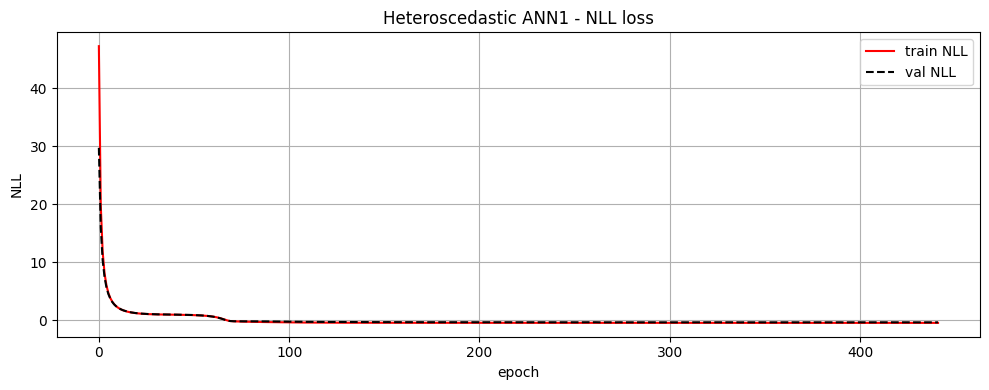

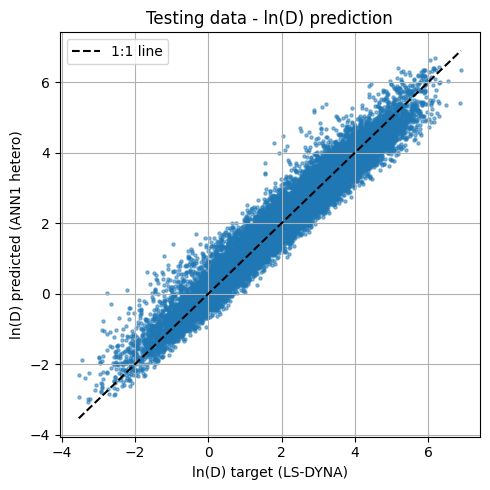

Fitted trend: phi_lnD = -0.137 * ln(Tslope) + 0.270


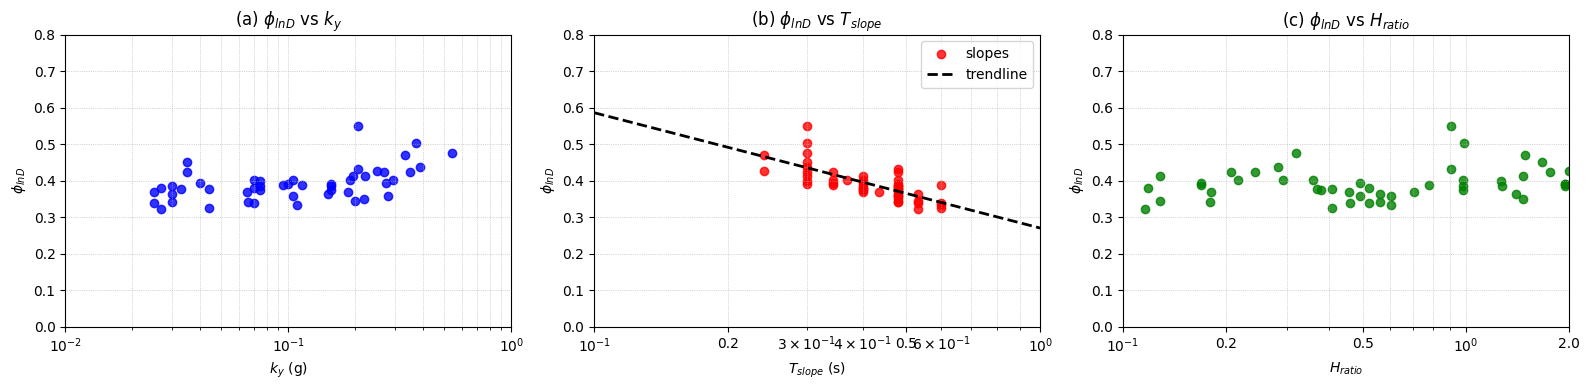

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# 1. Load data


SlopeParams = np.genfromtxt('SlopeParameters.csv', delimiter=',', skip_header=1)

ky_lin     = SlopeParams[:, 0]   # for plotting later (unlogged)
Ts_lin     = SlopeParams[:, 1]   # Tslip
Tslope_lin = SlopeParams[:, 8]
Hratio_lin = SlopeParams[:, 9]

ky     = ky_lin.copy()
Ts     = Ts_lin.copy()
Tslope = Tslope_lin.copy()
Hratio = Hratio_lin.copy()

GMPs = np.genfromtxt('GroundMotionParameters.csv', delimiter=',', dtype=float)
D    = np.genfromtxt('Max_Resultant_Displacement_EndofShake.csv', delimiter=',', dtype=float)


GMPs   = np.log(GMPs)
D      = np.log(D)
ky     = np.log(ky)
Ts     = np.log(Ts)
Tslope = np.log(Tslope)


n_slopes, n_gms = D.shape


# 2. Train/test slope indices


idx_train = [0,2,3,4,5,7,8,11,12,13,14,15,17,18,19,
             22,24,25,26,29,32,33,34,35,36,37,38,
             41,42,43,44,46,47,48]

idx_test  = [27,6,20,23,28,31,39,45,9,1,10,21,30,16,40]


# 3. Scale inputs


ky_scale     = ky     / (np.min(ky)     * 1.05)
Ts_scale     = Ts     / (np.min(Ts)     * 1.05)
Tslope_scale = Tslope / (np.min(Tslope) * 1.05)
Hratio_scale = Hratio / (np.max(Hratio) * 1.05)

PGV_scale    = GMPs[1, :] / (np.max(GMPs[1, :]) * 1.05)  # PGV is row 1

D_scale = D.copy()  # ln(D) used directly

# Build xscale (all slopes × all ground motions) for later full predictions
# Input order: [PGV, ky, Tslope, Hratio]
x_list = []
for i in range(n_slopes):
    x_i = np.vstack([
        PGV_scale,
        ky_scale[i]     * np.ones(n_gms),
        Tslope_scale[i] * np.ones(n_gms),
        Hratio_scale[i] * np.ones(n_gms)
    ]).T  # (1051,4)
    x_list.append(x_i)

xscale = np.vstack(x_list)        # (49*1051, 4)
D_flat = D_scale.flatten()        # (49*1051,)


# 4. Define heteroscedastic ANN (μ & σ)


class ANN1_Hetero(nn.Module):
    """
    4 -> 5 (sigmoid) -> 2
    Output:
      mu(x)         = out[..., 0:1]
      raw_sigma(x)  = out[..., 1:2]  (we transform it to sigma > 0 with softplus)
    """
    def __init__(self, input_dim=4, hidden_neurons=5):
        super(ANN1_Hetero, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, 2)

        nn.init.normal_(self.fc1.weight)
        nn.init.normal_(self.fc1.bias)
        nn.init.normal_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        out = self.fc2(x)
        mu = out[:, 0:1]
        raw_sigma = out[:, 1:2]
        return mu, raw_sigma


def gaussian_nll(mu, raw_sigma, y):
    """
    Negative log-likelihood for a normal distribution with
    mean = mu(x), std = sigma(x) > 0.

    L = 0.5 * [ ((y - mu)^2 / sigma^2) + ln(sigma^2) ]
      = 0.5 * [ ((y - mu)^2 / sigma^2) + 2 ln(sigma) ]
    """
    sigma = F.softplus(raw_sigma) + 1e-6  # ensure positivity; softplus ~ log(1+exp(.))
    nll = 0.5 * (((y - mu) ** 2) / (sigma ** 2) + 2.0 * torch.log(sigma))
    return nll.mean()


# 5. Prepare train/test sets


# Build training set
X_train_list = []
y_train_list = []

for idx in idx_train:
    X_i = np.vstack([
        PGV_scale,
        ky_scale[idx]     * np.ones(n_gms),
        Tslope_scale[idx] * np.ones(n_gms),
        Hratio_scale[idx] * np.ones(n_gms)
    ]).T  # (1051,4)

    y_i = D_scale[idx, :]  # (1051,)

    X_train_list.append(X_i)
    y_train_list.append(y_i)

X_train_np = np.vstack(X_train_list)                 # (len(idx_train)*1051, 4)
y_train_np = np.hstack(y_train_list).reshape(-1, 1)  # (len(idx_train)*1051, 1)

# Build testing set
X_test_list = []
y_test_list = []

for idx in idx_test:
    X_i = np.vstack([
        PGV_scale,
        ky_scale[idx]     * np.ones(n_gms),
        Tslope_scale[idx] * np.ones(n_gms),
        Hratio_scale[idx] * np.ones(n_gms)
    ]).T

    y_i = D_scale[idx, :]
    X_test_list.append(X_i)
    y_test_list.append(y_i)

X_test_np = np.vstack(X_test_list)
y_test_np = np.hstack(y_test_list).reshape(-1, 1)

# Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32, device=device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32, device=device)

X_all   = torch.tensor(xscale,    dtype=torch.float32, device=device)


# 6. Train heteroscedastic model with progress printing


hidden_neurons = 5
max_epochs     = 500
patience       = 50
batch_size     = 256
learning_rate  = 1e-3

model = ANN1_Hetero(input_dim=4, hidden_neurons=hidden_neurons).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_train = X_train.shape[0]
num_batches = int(np.ceil(n_train / batch_size))

best_val_loss  = np.inf
patience_count = 0

train_losses = []
val_losses   = []

print("Starting training...")

for epoch in range(max_epochs):
    model.train()
    perm = torch.randperm(n_train, device=device)

    epoch_train_loss = 0.0
    for b in range(num_batches):
        idx_batch = perm[b*batch_size : (b+1)*batch_size]
        xb = X_train[idx_batch]
        yb = y_train[idx_batch]

        optimizer.zero_grad()
        mu_pred, raw_sigma_pred = model(xb)
        loss = gaussian_nll(mu_pred, raw_sigma_pred, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * xb.size(0)

    epoch_train_loss /= n_train

    # Validation
    model.eval()
    with torch.no_grad():
        mu_val, raw_sigma_val = model(X_test)
        val_loss = gaussian_nll(mu_val, raw_sigma_val, y_test).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{max_epochs} "
              f"| train_NLL={epoch_train_loss:.4f} | val_NLL={val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        patience_count = 0
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_count += 1

    if patience_count >= patience:
        print(f"Early stopping at epoch {epoch+1}, best val_NLL={best_val_loss:.4f}")
        break

# Load best weights
model.load_state_dict(best_state_dict)


# 7. Predictions: μ and σ on train/test/all


model.eval()
with torch.no_grad():
    mu_train, raw_sigma_train = model(X_train)
    mu_test,  raw_sigma_test  = model(X_test)
    mu_all,   raw_sigma_all   = model(X_all)

mu_train_np       = mu_train.cpu().numpy()
mu_test_np        = mu_test.cpu().numpy()
mu_all_np         = mu_all.cpu().numpy().reshape(-1)
sigma_train_np    = (F.softplus(raw_sigma_train) + 1e-6).cpu().numpy()
sigma_test_np     = (F.softplus(raw_sigma_test)  + 1e-6).cpu().numpy()
sigma_all_np      = (F.softplus(raw_sigma_all)   + 1e-6).cpu().numpy().reshape(-1)


# 8. Total sigma_lnD based on residuals


residuals_all = D_flat - mu_all_np   # ln(D_obs) - ln(D_pred)
std_tot = np.std(residuals_all)
print('Total Sigma_lnD (from residuals): ', np.round(std_tot, 3))


# 9. Plots comparable to the paper


# --- 9.1 Training & validation NLL vs epoch ---
plt.figure(figsize=(10,4))
plt.plot(train_losses, 'r', label='train NLL')
plt.plot(val_losses,   'k--', label='val NLL')
plt.title('Heteroscedastic ANN1 - NLL loss')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9.2 Predicted vs target ln(D) for TEST data (like Fig. 5, but for ANN1) ---
plt.figure(figsize=(5,5))
y_test_flat  = y_test_np.flatten()
mu_test_flat = mu_test_np.flatten()

dmin = min(y_test_flat.min(), mu_test_flat.min())
dmax = max(y_test_flat.max(), mu_test_flat.max())

plt.scatter(y_test_flat, mu_test_flat, s=5, alpha=0.5)
plt.plot([dmin, dmax], [dmin, dmax], 'k--', label='1:1 line')
plt.xlabel('ln(D) target (LS-DYNA)')
plt.ylabel('ln(D) predicted (ANN1 hetero)')
plt.title('Testing data - ln(D) prediction')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 9.3 φ_lnD per slope vs ky, Tslope, Hratio
# =========================

phi_slope = np.zeros(n_slopes)
for i in range(n_slopes):
    start = i * n_gms
    end   = (i + 1) * n_gms
    res_i = residuals_all[start:end]
    phi_slope[i] = np.std(res_i)

plt.figure(figsize=(16,4))

# -------- (a) φ vs ky --------
plt.subplot(1,3,1)
plt.scatter(ky_lin, phi_slope, c='blue', alpha=0.8)
plt.xscale('log')
plt.xlabel(r'$k_y$ (g)')
plt.ylabel(r'$\phi_{lnD}$')
plt.title('(a) $\phi_{lnD}$ vs $k_y$')
plt.xlim(1e-2, 1e0)
plt.ylim(0.0, 0.8)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.xticks([1e-2, 1e-1, 1e0], [r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])

# -------- (b) φ vs Tslope + regression line --------
plt.subplot(1,3,2)
plt.scatter(Tslope_lin, phi_slope, c='red', alpha=0.8, label='slopes')
plt.xscale('log')
plt.xlabel(r'$T_{slope}$ (s)')
plt.ylabel(r'$\phi_{lnD}$')
plt.title('(b) $\phi_{lnD}$ vs $T_{slope}$')
plt.xlim(1e-1, 1e0)
plt.ylim(0.0, 0.8)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Fit φ = a * ln(Tslope) + b (like paper’s Eq. 6) ---
mask = Tslope_lin > 0.0
x_log = np.log(Tslope_lin[mask])
y_phi = phi_slope[mask]

a, b = np.polyfit(x_log, y_phi, 1)
print(f"Fitted trend: phi_lnD = {a:.3f} * ln(Tslope) + {b:.3f}")


Ts_grid = np.logspace(-1, 0, 100)
phi_fit = a * np.log(Ts_grid) + b

plt.plot(Ts_grid, phi_fit, 'k--', linewidth=2, label='trendline')
plt.legend()


plt.xticks([1e-1, 2e-1, 5e-1, 1e0],
           [r'$10^{-1}$', '0.2', '0.5', r'$10^{0}$'])

# -------- (c) φ vs Hratio --------
plt.subplot(1,3,3)
plt.scatter(Hratio_lin, phi_slope, c='green', alpha=0.8)
plt.xscale('log')
plt.xlabel(r'$H_{ratio}$')
plt.ylabel(r'$\phi_{lnD}$')
plt.title('(c) $\phi_{lnD}$ vs $H_{ratio}$')


plt.xlim(1e-1, 2.0)
plt.ylim(0.0, 0.8)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.xticks([1e-1, 2e-1, 5e-1, 1e0, 2.0],
           [r'$10^{-1}$', '0.2', '0.5', r'$10^{0}$', '2.0'])

plt.tight_layout()
plt.show()

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score

y_true = y_test_np.flatten()
y_pred = mu_test_np.flatten()

MAE  = mean_absolute_error(y_true, y_pred)
R2   = r2_score(y_true, y_pred)
R    = np.sqrt(R2)

res_test = y_true - y_pred
sigma_lnD_test = np.std(res_test)

print(f"Test MAE (lnD): {MAE:.3f}")
print(f"Test R:         {R:.3f}")
print(f"Test σ_lnD:     {sigma_lnD_test:.3f}")


Test MAE (lnD): 0.339
Test R:         0.969
Test σ_lnD:     0.439


In [5]:
sigma_pred_mean = np.mean(sigma_all_np)
sigma_pred_std  = np.std(sigma_all_np)

print(f"Mean predicted σ(x): {sigma_pred_mean:.3f}")
print(f"Std of σ(x):         {sigma_pred_std:.3f}")


Mean predicted σ(x): 0.409
Std of σ(x):         0.033


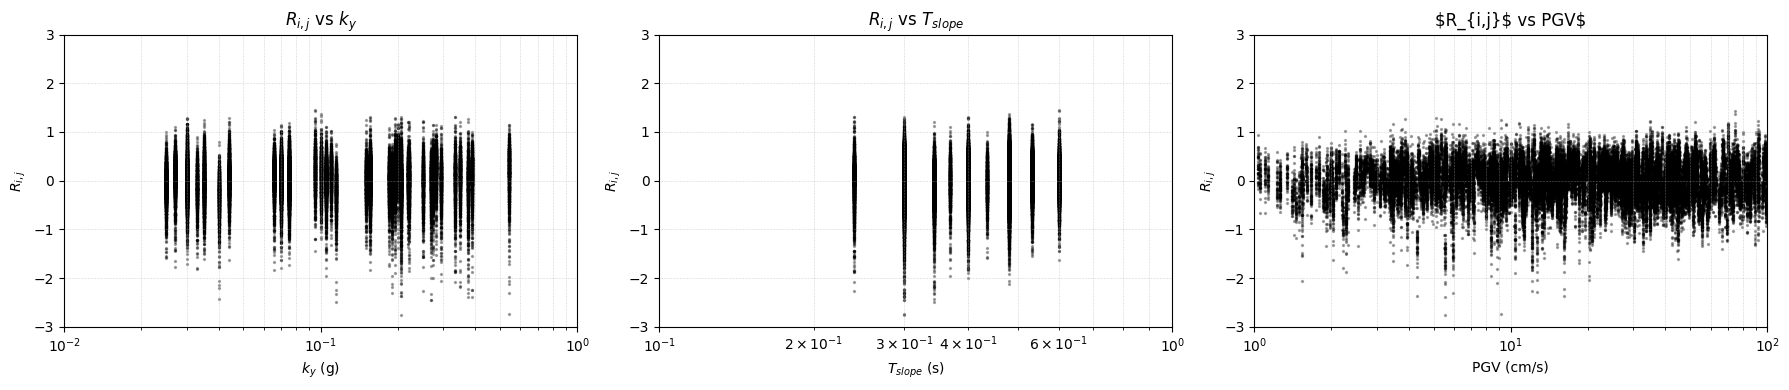

In [8]:

# Residual plots R_ij vs ky, Tslope, PGV


# Build per-sample inputs
PGV_lin    = np.exp(GMPs[1, :])                 # PGV in cm/s
PGV_rep    = np.tile(PGV_lin, n_slopes)

ky_rep     = np.repeat(ky_lin, n_gms)
Tslope_rep = np.repeat(Tslope_lin, n_gms)

R = residuals_all  # ln(D_obs) - mu(x)

plt.figure(figsize=(18,4))

# -------- Panel (a): R vs ky --------
plt.subplot(1,3,1)
plt.scatter(ky_rep, R, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel(r'$k_y$ (g)')
plt.ylabel(r'$R_{i,j}$')
plt.title(r'$R_{i,j}$ vs $k_y$')
plt.xlim(1e-2, 1e0)
plt.ylim(-3, 3)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

# -------- Panel (b): R vs Tslope --------
plt.subplot(1,3,2)
plt.scatter(Tslope_rep, R, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel(r'$T_{slope}$ (s)')
plt.ylabel(r'$R_{i,j}$')
plt.title(r'$R_{i,j}$ vs $T_{slope}$')
plt.xlim(1e-1, 1e0)
plt.ylim(-3, 3)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

# -------- Panel (c): R vs PGV --------
plt.subplot(1,3,3)
plt.scatter(PGV_rep, R, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel('PGV (cm/s)')
plt.ylabel(r'$R_{i,j}$')
plt.title(r'$R_{i,j}$ vs PGV$')
plt.xlim(1e0, 1e2)
plt.ylim(-3, 3)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

plt.tight_layout()
plt.show()


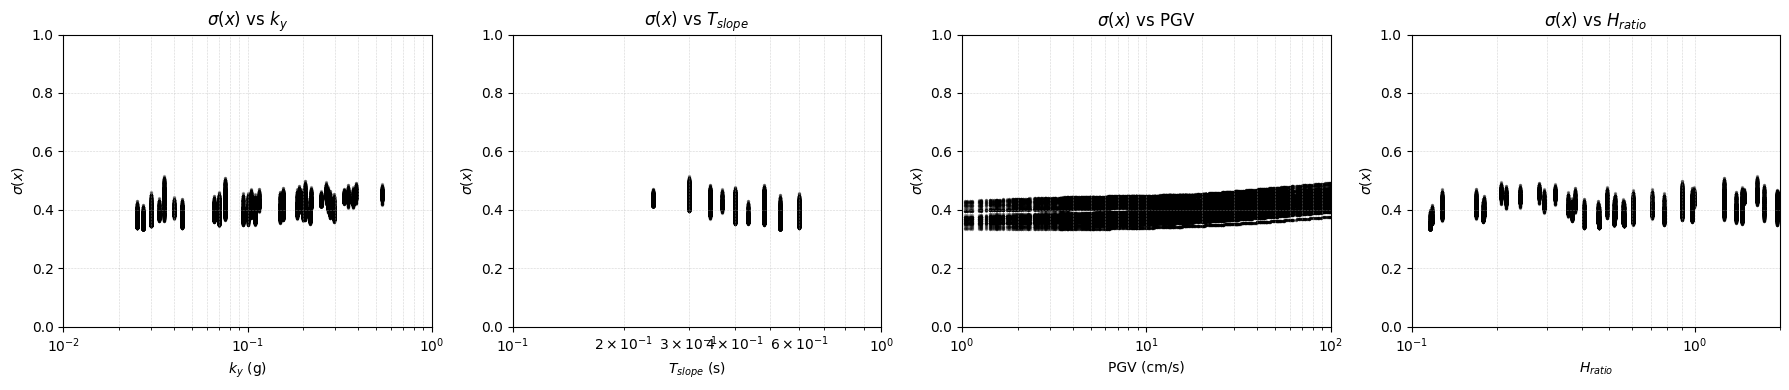

In [9]:

# σ(x) vs ky, Tslope, PGV, Hratio (Formatted Like Paper)


# Build per-sample inputs
PGV_lin    = np.exp(GMPs[1, :])                 # PGV in cm/s
PGV_rep    = np.tile(PGV_lin, n_slopes)

ky_rep     = np.repeat(ky_lin, n_gms)
Tslope_rep = np.repeat(Tslope_lin, n_gms)
Hratio_rep = np.repeat(Hratio_lin, n_gms)

sigma = sigma_all_np  # predicted σ(x) for all samples

plt.figure(figsize=(18,4))

# -------- (a) σ(x) vs ky --------
plt.subplot(1,4,1)
plt.scatter(ky_rep, sigma, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel(r'$k_y$ (g)')
plt.ylabel(r'$\sigma(x)$')
plt.title(r'$\sigma(x)$ vs $k_y$')
plt.xlim(1e-2, 1e0)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

# -------- (b) σ(x) vs Tslope --------
plt.subplot(1,4,2)
plt.scatter(Tslope_rep, sigma, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel(r'$T_{slope}$ (s)')
plt.ylabel(r'$\sigma(x)$')
plt.title(r'$\sigma(x)$ vs $T_{slope}$')
plt.xlim(1e-1, 1e0)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

# -------- (c) σ(x) vs PGV --------
plt.subplot(1,4,3)
plt.scatter(PGV_rep, sigma, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel('PGV (cm/s)')
plt.ylabel(r'$\sigma(x)$')
plt.title(r'$\sigma(x)$ vs PGV')
plt.xlim(1e0, 1e2)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

# -------- (d) σ(x) vs Hratio --------
plt.subplot(1,4,4)
plt.scatter(Hratio_rep, sigma, s=2, alpha=0.3, color='black')
plt.xscale('log')
plt.xlabel(r'$H_{ratio}$')
plt.ylabel(r'$\sigma(x)$')
plt.title(r'$\sigma(x)$ vs $H_{ratio}$')
plt.xlim(1e-1, 2.0)
plt.ylim(0.0, 1.0)
plt.grid(True, which='both', linestyle=':', linewidth=0.4)

plt.tight_layout()
plt.show()
